In [60]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import json
import inspect
import collections
from collections import OrderedDict
from datetime import datetime as dt
import time
import re
import ast


In [2]:
response = requests.get(url='https://store.steampowered.com/appreviews/413150?json=1').json()

In [3]:
#response

In [4]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()


In [5]:
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [6]:
#def get_app_id(game_name):
#    response = requests.get(url=f'https://store.steampowered.com/search/?term={game_name}&category1=998', headers={'User-Agent': 'Mozilla/5.0'})
#    soup = BeautifulSoup(response.text, 'html.parser')
#    app_id = soup.find(class_='search_result_row')['data-ds-appid']
#    
#    return app_id

In [7]:
#To get a bunch of app IDs at once
def get_n_appids(n=100, filter_by='topsellers'):
    appids = []
    url = f'https://store.steampowered.com/search/?category1=998&filter={filter_by}&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append(row['data-ds-appid'])

    return appids[:n]

In [8]:
#see how long it takes to execute this cell
start = time.time()

reviews = []
appids = get_n_appids(100) #100 app/"game" IDs, 100 top sellers?
for appid in appids:
    reviews += get_n_reviews(appid, 100)


end = time.time()

total_time = end - start
print("\n" + str(total_time))


57.637343406677246


In [9]:
#want to see how reviews looks like.
reviews

#first of all can look up who wrote the review/go to the actual review on Steam by looking up 'steamid'
#might be good to only look at reviews with substantial playtime_forever & playtime_last_two_weeks -> need to parse from "author"
#also 'votes_up' to see how many people found it helpful & votes_funny
#weighted_vote_score - might be good to pull it in to see how it varies

[{'recommendationid': '132534295',
  'author': {'steamid': '76561198012052601',
   'num_games_owned': 2757,
   'num_reviews': 39,
   'playtime_forever': 2890,
   'playtime_last_two_weeks': 2890,
   'playtime_at_review': 2625,
   'last_played': 1676067819},
  'language': 'english',
  'review': '[h1]A dream for every Potterhead and those who want to become one![/h1]\n[b][u]Spoiler free Review![/u][/b]\n\n\nSometimes games are getting released with way too much hype. Forspoken, as an example, would be such a game. Either is it because of bad optimization or misinformation by the studio, the disappointment can end up being immeasurable for people who already pre-ordered these games, or people who have those games on their wishlist for months. Sadly, we had a lot of those lately. Don\'t even get me started with license games in general....\n\nHogwarts Legacy, on the other hand, shows that sometimes the hype train can be true.\n\nI don\'t usually pre-order games anymore, but the premise of b

In [10]:
df_init = pd.DataFrame(reviews)[['review','author','votes_up','votes_funny','weighted_vote_score', 'voted_up']]


In [11]:
df_init.shape

(9400, 6)

In [12]:
df_init.head()

,review,author,votes_up,votes_funny,weighted_vote_score,voted_up
0,[h1]A dream for every Potterhead and those who...,"{'steamid': '76561198012052601', 'num_games_ow...",3239,75,0.945971667766571045,True
1,The great thing about this game is if there's ...,"{'steamid': '76561198986421535', 'num_games_ow...",3371,1792,0.92505258321762085,True
2,You can do everything you can't do in real lif...,"{'steamid': '76561198330419772', 'num_games_ow...",1348,1435,0.921482622623443604,True
3,*Revelio*\n[spoiler]10/10[/spoiler],"{'steamid': '76561198031166668', 'num_games_ow...",2237,924,0.919901251792907715,True
4,It's crazy how respecting the fans and source ...,"{'steamid': '76561198037743369', 'num_games_ow...",1918,115,0.91523277759552002,True


In [13]:
#Need to parse out the data from the author field
pd.set_option('display.max_colwidth', None)
print(df_init['author'].head(1)) #example of what this author column looks like.

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 2890, 'playtime_last_two_weeks': 2890, 'playtime_at_review': 2625, 'last_played': 1676067819}
Name: author, dtype: object


### Extracting more data from the author column

In [14]:
#Convert this column to list first
df_init['author'].head()

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 2890, 'playtime_last_two_weeks': 2890, 'playtime_at_review': 2625, 'last_played': 1676067819}
1            {'steamid': '76561198986421535', 'num_games_owned': 666, 'num_reviews': 8, 'playtime_forever': 12, 'playtime_last_two_weeks': 12, 'playtime_at_review': 12, 'last_played': 1675845082}
2        {'steamid': '76561198330419772', 'num_games_owned': 228, 'num_reviews': 82, 'playtime_forever': 102, 'playtime_last_two_weeks': 102, 'playtime_at_review': 102, 'last_played': 1675859245}
3       {'steamid': '76561198031166668', 'num_games_owned': 4045, 'num_reviews': 45, 'playtime_forever': 693, 'playtime_last_two_weeks': 693, 'playtime_at_review': 693, 'last_played': 1675999943}
4     {'steamid': '76561198037743369', 'num_games_owned': 695, 'num_reviews': 19, 'playtime_forever': 3741, 'playtime_last_two_weeks': 3741, 'playtime_at_review': 3347, 'last_played': 1676075828}
Name: author, dtype:

In [15]:
author_fields = df_init['author'].values.tolist()

In [16]:
author_df = pd.DataFrame(author_fields, columns = ['steamid','num_games_owned','num_reviews','playtime_forever',
                                                   'playtime_last_two_weeks','playtime_at_review','last_played'])

In [17]:
author_df.shape

(9400, 7)

In [64]:
df = pd.concat([df_init, author_df], axis=1)

In [65]:
#df.head() #the author columns are included now

In [66]:
df.columns

Index(['review', 'author', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'voted_up', 'steamid', 'num_games_owned', 'num_reviews',
       'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review',
       'last_played'],
      dtype='object')

In [67]:
#subset and rearrange columns
#won't really need "last_played"
df = df[['steamid','review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [68]:
df.head()
#first review is weird.

steamid  \
0  76561198012052601   
1  76561198986421535   
2  76561198330419772   
3  76561198031166668   
4  76561198037743369   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [69]:
#Proportion of reviews with thumbs up or down
df['voted_up'].value_counts()

True     7662
False    1738
Name: voted_up, dtype: int64

In [70]:
#examples of reviews that received a thumbs down
df[df['voted_up']==False]

,steamid,review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up
15,76561198121347683,"Words can't describe how disappointed I am in this game. This was advertised as ""make your own path"" kind of game, yet it can't be further away from the truth. There is one path, and it's the one the game gives you. There is no becoming a dark wizard, or a good one... you're just the character the game tells you to be.\n\nThe whole game is lifeless, NPCs don't react to anything you do, you can talk to some of them but that's it. You can go around casting spells, no one will even look at you or react the slightest. You can go and enter people's house after forcing their locks, go through their chests, they won't say or do a thing, they just act like you're not even there. \n\nMost of the time you can't jump to places, invisible walls everywhere, making exploration very linear and flavorless. Combat is fun, but I'm still looking for difficulty. Basically entered one of the most dangerous places, the Forbidden Forest, after 2 hours playing and defeated everything that came my way without breaking a sweat, there is no real danger or even sense of danger, and of course you can't attack centors, because yeah... you're not a bad person, so the game won't let you do bad things. \n\nYou can fly on a broom, and again, it's slow, no sensation or feeling of speed, you can go into an obstacle at full speed and you will just stop, no impact, no animation, nothing. You just stop like it's okay to ram into a wall. \n\nThe only decent thing about the game so far is the story. It's well designed, for now, but there is not much choices or decisions to take, and the only few really don't change anything to the story... you just go with it and follow the game's lead. It's basically a playable cinematic.\n\nSo to sum it up, it is yet again a very expensive game that brings nothing new to the table, with empty promises and seemingly half finished features. Was expecting this to be a Skyrim with HP world, turned out to be a plain adventure game you can't even play with your friends.\n\n4/10",102,7,2261,2261,2041,765,49,0.743036568164825439,False
16,76561198175093091,[h1]DENUVO REMUVO[h1],152,89,573,573,397,537,194,0.740489721298217773,False
18,76561198208400235,"EDIT: All of this still applies after Day 1 patch. It has done absolutely nothing in the performance department\n\nLet me start by saying that when this game works it is fantastic and there are tons of people the game runs well for that are around my specs or even lower with 10-series GPUs. I am not trying to ruin that for anyone and I entirely understand why people love this game and are going to upvote in reviews or even get mad down in the replies. \n\nHowever this is not the case for everyone and plenty of others with high end systems are having problems and the game is truly impossible to experience with such horrendous stability issues. Performance problems are being spammed on their official bug tracker website, under their most popular replies on all recent twitter posts, and discussions from the community on Steam/Reddit. So downplaying it cus you want a hive-mind to circlejerk your favorite game is foolish. Ignorant comments from actual robots such as ""mUH gAmeE wORk sO uR cOmPUteR bAD"" are everywhere and completely useless to the discussion or finding out the issue/fix, these comments will be ignored.\n\nIt is absolutely unacceptable to sell an early launch of a game as a product, make people pay more than base price, then have a large chunk of players with a massive range of specs and settings realize after the 1-2 hour tutorial when you finally get to roam around that the game is absolutely broken, unplayable, and unoptimized. If you have to wait for a patch or game ready driver then why even sell the early release of the game at all?\n\nMy specs more than clear any requirement for this game as well as 

#### Import NLP libraries

In [71]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

#### Next: lowercase, remove special characters/only keep letters, remove stop words, etc.

In [72]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

#Create a function that tries to clean the reviews
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower() #lowercase
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext) #remove weblinks
    rem_num = re.sub('[0-9]+', '', rem_url) #remove numbers
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')] #remove stop words
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)




In [73]:
#First row looks weird..try taking it out
df = df.iloc[1:]

In [74]:
df.head()

,steamid,review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up
1,76561198986421535,The great thing about this game is if there's any bugs the devs can just say it's magic.,666,8,12,12,12,3371,1792,0.92505258321762085,True
2,76561198330419772,"You can do everything you can't do in real life, like casting magic and talking to girls\n",228,82,102,102,102,1348,1435,0.921482622623443604,True
3,76561198031166668,*Revelio*\n[spoiler]10/10[/spoiler],4045,45,693,693,693,2237,924,0.919901251792907715,True
4,76561198037743369,It's crazy how respecting the fans and source material actually works. Who would've thought?,695,19,3741,3741,3347,1918,115,0.91523277759552002,True
5,76561198051792976,"[b]For me this is one of best Open World game, I've ever played.[/b]\n\n[b]Storyline - 9/10[/b]\nStory is presented in a very nice form like in Harry Poter movies. In most of the dialogue you can choose what to say. We have many ways to pass the mission. Each mission is interesting and different than earlier. We also have riddle games and good sidequests.\n\n[b]Gameplay - 9/10[/b]\nBeautiful open world giving many opportunities for the player. We can explore Hogwart, caves, forests, mountains and doing much more things. The map is very large. Herbalism and Alchemy are important and helps a lot, we also can upgrade equipments. We can have a real wizzard adventure. Fight feeling is pleasant. Sometimes we are blocking on a small obstacle but in comparison to other games it is not very annoying.\n\n[b]Characters - 10/10[/b]\nEach character has its own charm. Characters are well matched to the storyline and to the environment. We also can choose the path of the main character be good wizzard or bad (unforgivable spells) but the game won't punish us for it.\n\n[b]Graphics - 10/10[/b]\nGraphics in this game is amazing. Even the smallest details are well refined, for example when we move the grass moves with us. Graphics capabilities used in 100%. The movement of water, clouds are very well refined. We can see falling leaves, changing weather. It makes a huge impression.\n\n[b]Sounds - 9/10[/b]\nMusic and ambient sounds in this game fits great. We can listen climatic music which is selected for each moment of the game. Character voices are not my favourite but it fits into character. There is a lot of music known from the movies.\n\n[b]Overall - 9.5/10[/b]\nIf you are thinking about purchase this game, if you like open world and action RPG games, I would recommend these game for you, and I guarantee a lot of fun comes from that game. This is well made game not only for Harry Potters fans, but for everyone.",2422,3,1452,1452,1304,602,7,0.908142685890197754,True


#### Apply the preprocess function

In [75]:
start = time.time()

df['clean_review']=df['review'].map(lambda s:preprocess(s))

end = time.time()

total_time = end - start
print("\n" + str(total_time))


348.71419286727905


In [76]:
#keep a copy here just in case.
df_backup = df.copy()

In [77]:
#df.head()

In [78]:
#df['steamid'].nunique()

In [79]:
#Again, reorder and subset columns
df = df[['clean_review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [80]:
df.head()

,clean_review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up
1,great thing game bugs devs say magic,666,8,12,12,12,3371,1792,0.92505258321762085,True
2,everything real life like casting magic talking girls,228,82,102,102,102,1348,1435,0.921482622623443604,True
3,revelio spoiler spoiler,4045,45,693,693,693,2237,924,0.919901251792907715,True
4,crazy respecting fans source material actually works would thought,695,19,3741,3741,3347,1918,115,0.91523277759552002,True
5,one best open world game ever played storyline story presented nice form like harry poter movies dialogue choose say many ways pass mission mission interesting different earlier also riddle games good sidequests gameplay beautiful open world giving many opportunities player explore hogwart caves forests mountains much things map large herbalism alchemy important helps lot also upgrade equipments real wizzard adventure fight feeling pleasant sometimes blocking small obstacle comparison games annoying characters character charm characters well matched storyline environment also choose path main character good wizzard bad unforgivable spells game punish graphics graphics game amazing even smallest details well refined example move grass moves graphics capabilities used movement water clouds well refined see falling leaves changing weather makes huge impression sounds music ambient sounds game fits great listen climatic music selected moment game character voices favourite fits character lot music known movies overall thinking purchase game like open world action rpg games would recommend game guarantee lot fun comes game well made game harry potters fans everyone,2422,3,1452,1452,1304,602,7,0.908142685890197754,True


In [82]:
#No nulls
df.isna().sum()

clean_review               0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
votes_up                   0
votes_funny                0
weighted_vote_score        0
voted_up                   0
dtype: int64

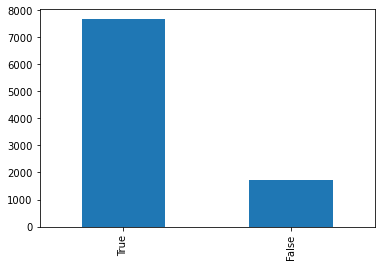

In [83]:
#Compare target class
df['voted_up'].value_counts().plot(kind='bar')

In [84]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [85]:
df_pos = df[df['voted_up']==True]
df_pos.shape

(7661, 10)

In [86]:
df_neg = df[df['voted_up']==False]
df_neg.shape

(1738, 10)

In [87]:
#Build wordcloud
wc = WordCloud(stopwords = stop_words, collocations = False, max_font_size=55, max_words=50, background_color='white')

## Word Cloud for Reviews Voted Up

(-0.5, 399.5, 199.5, -0.5)

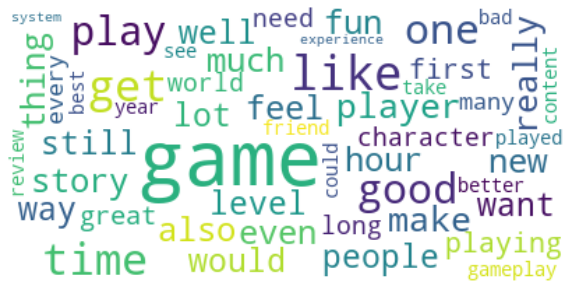

In [88]:
wc.generate(' '.join(df_pos['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Up Reviews WordCloud

## Word Cloud for Reviews Voted Down

(-0.5, 399.5, 199.5, -0.5)

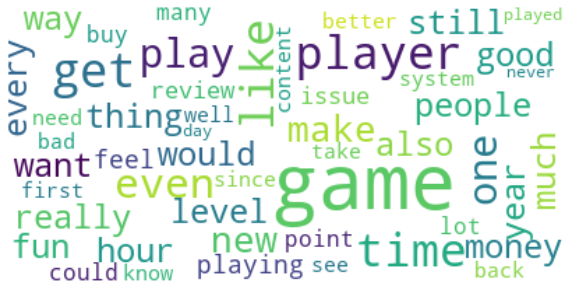

In [89]:
wc.generate(' '.join(df_neg['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Down Reviews Wordcloud

### Change Target Column to Binary -> just change bool to int()


In [90]:
df['voted_up_target'] = df['voted_up'].astype(int)

In [91]:
df.head()

,clean_review,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,votes_up,votes_funny,weighted_vote_score,voted_up,voted_up_target
1,great thing game bugs devs say magic,666,8,12,12,12,3371,1792,0.92505258321762085,True,1
2,everything real life like casting magic talking girls,228,82,102,102,102,1348,1435,0.921482622623443604,True,1
3,revelio spoiler spoiler,4045,45,693,693,693,2237,924,0.919901251792907715,True,1
4,crazy respecting fans source material actually works would thought,695,19,3741,3741,3347,1918,115,0.91523277759552002,True,1
5,one best open world game ever played storyline story presented nice form like harry poter movies dialogue choose say many ways pass mission mission interesting different earlier also riddle games good sidequests gameplay beautiful open world giving many opportunities player explore hogwart caves forests mountains much things map large herbalism alchemy important helps lot also upgrade equipments real wizzard adventure fight feeling pleasant sometimes blocking small obstacle comparison games annoying characters character charm characters well matched storyline environment also choose path main character good wizzard bad unforgivable spells game punish graphics graphics game amazing even smallest details well refined example move grass moves graphics capabilities used movement water clouds well refined see falling leaves changing weather makes huge impression sounds music ambient sounds game fits great listen climatic music selected moment game character voices favourite fits character lot music known movies overall thinking purchase game like open world action rpg games would recommend game guarantee lot fun comes game well made game harry potters fans everyone,2422,3,1452,1452,1304,602,7,0.908142685890197754,True,1


### Remove (Consecutively) Repeated Words

In [59]:
df.iloc[2] #Ex) "spoiler spoiler"

clean_review               revelio spoiler spoiler
num_games_owned                               4045
num_reviews                                     45
playtime_forever                               693
playtime_last_two_weeks                        693
playtime_at_review                             693
votes_up                                      2237
votes_funny                                    924
weighted_vote_score           0.919901251792907715
voted_up                                      True
voted_up_target                                  1
Name: 3, dtype: object

In [92]:
#Use this to get rid of consecutive duplicates ONLY
df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')

#Use this to removes non-consecutive duplicates
#df['clean_review'] = (df['clean_review'].str.split()
#                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
#                              .str.join(' '))


<ipython-input-92-97b2061ddf58>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')


In [94]:
df.iloc[2]

clean_review                    revelio spoiler
num_games_owned                            4045
num_reviews                                  45
playtime_forever                            693
playtime_last_two_weeks                     693
playtime_at_review                          693
votes_up                                   2237
votes_funny                                 924
weighted_vote_score        0.919901251792907715
voted_up                                   True
voted_up_target                               1
Name: 3, dtype: object

### Additional Feature Engineering

In [97]:
# Review Length
df['review_length'] = df['clean_review'].apply(len)

Text(0.5, 1.0, 'Distribution of Review Lengths')

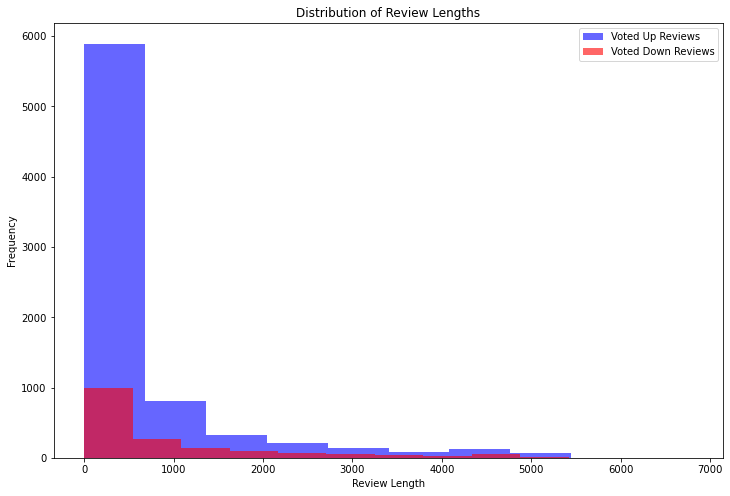

In [105]:
plt.figure(figsize=(12, 8))

df[df.voted_up_target == 1].review_length.plot(kind='hist', color='blue', 
                                       label='Voted Up Reviews', alpha=0.6)
df[df.voted_up_target == 0].review_length.plot(kind='hist', color='red', 
                                       label='Voted Down Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")
plt.title('Distribution of Review Lengths')

In [ ]:
#https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

### Address the Unequal Text Length Problem(?)

#### Split data into training and test set

In [95]:
#df.head()

In [44]:
#X_train, X_val, y_train, y_val = train_test_split(train_df.OriginalTweet.values, train_df.Sentiment.values,
#                                                  stratify=train_df.Sentiment.values,
#                                                  test_size=.1, shuffle=True, random_state=42)

#X_train.shape, X_val.shape, y_train.shape, y_val.shape